In [104]:
import numpy as np
from numpy import eye, array, asarray
from numpy.linalg import inv
from numpy.random import randn
import math
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams.update({'font.size': 18})
develop = False
rng = np.random.default_rng()

In [105]:
class KalmanFilter:
    def __init__(self):
        self.M = None
        self.H = None
        self.mu = None
        self.Sigma = None
        self.Sigma_y = None
        self.Q = None
        
    def predict_response(self):
        return self.H @ self.mu
    
    # KF assimilation
    def update(self, y_t):
        # Predict y to measure innovation
        y_hat = self.predict_response()
        # Calculate Kalman gain
        K = self.Sigma @ self.H.T @ inv(self.H @ self.Sigma @ self.H.T + self.Sigma_y)
        # Update belief
        I = np.identity(self.mu.size)
        self.mu = self.mu + K @ (y_t - y_hat)
        self.Sigma = (I-K@self.H)@self.Sigma
    
    # time dynamics
    def predict(self):
        self.mu = self.M @ self.mu
        self.Sigma = self.M @ self.Sigma @ self.M.T + self.Q

In [106]:
class ExtendedKalmanFilter(KalmanFilter):
    def __init__(self):
        super().__init__()
        self.h = None
        self.h_jacobian_at_x = None
    
    def predict_response(self):
        self.H = self.h_jacobian_at_x(self.mu)
        return self.h(self.mu)

In [107]:
class RadarSim(object):
    """ Simulates the radar signal returns from an object flying 
    at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once for each
        new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err


def h_jacobian_at(x):
    """ compute Jacobian of H matrix for state x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])


def hx(x):
    """ compute measurement for slant range that would correspond 
    to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

In [108]:
# create radar object
dt = 0.05
T = 50
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
if develop:
    print("develop")
    Tn = int(T/dt)
    observed_flight_slant = []
    track = []
    for t in range(Tn):
        observed_flight_slant.append(radar.get_range())
        track.append((radar.pos, radar.vel, radar.alt))
    observed_flight_slant = asarray(observed_flight_slant)
    track = asarray(track)
    np.savetxt("observed_flight_slant.csv", observed_flight_slant, delimiter=",")
    np.savetxt("true_flight_state.csv", track, delimiter=",")
    print(track)
    print(observed_flight_slant)
else:
    print("not develop")
    observed_flight_slant = np.loadtxt("observed_flight_slant.csv", delimiter=",")
    track = np.loadtxt("true_flight_state.csv", delimiter=",")
    Tn = observed_flight_slant.size
    print(track)
    print(observed_flight_slant)

not develop
[[   4.99978866   99.99577327  999.7581014 ]
 [   9.99296798   99.86358634  999.73234139]
 [  14.99223055   99.98525141  999.60326474]
 ...
 [4834.79994096   98.83079918  993.96712022]
 [4839.74921734   98.98552754  994.0523194 ]
 [4844.70087004   99.03305415  993.85779645]]
[ 999.83034648  999.92374118 1000.07302056 1000.3339411   999.99286379
 1002.79372693  999.17900064  999.93017758  997.33908572  995.49442682
 1000.08581629  999.37401272  996.12094802 1001.99419722 1000.31722021
 1004.81279789 1006.29510023 1009.48188597 1011.86970078 1010.68509499
 1007.30714998 1010.17358705 1006.90093652 1016.93391949 1012.34897238
 1008.87032513 1013.29932882 1008.34227575 1014.11329244 1015.71086746
 1011.45548371 1006.88433958 1012.31468897 1024.99043689 1011.49323135
 1018.21954611  999.89997133 1020.00544252 1020.21787254 1011.51939521
 1019.33057707 1023.78574849 1009.71589011 1009.44612888 1036.39035479
 1023.90294048 1028.31465375 1030.24757431 1041.85366494 1031.62930972
 1

In [109]:
# initialize ekf
ekf = ExtendedKalmanFilter()
# prior
ekf.mu = array([-100, 200, 2000])
ekf.Sigma = eye(3)*50
# Time dynamics from linear approximation
ekf.M = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt
ekf.Q = array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 1]]) * 0.001
# Observation noise and maps
ekf.Sigma_y = 50 # 5% of altitude 1000 
ekf.h = hx
ekf.h_jacobian_at_x = h_jacobian_at

In [110]:
# Assimilate over time
xs = []
#track = []
for t in range(int(T/dt)):
    #mu_prior.append(kf.mu[0])
    # assimilation step
    y = observed_flight_slant[t]
    print(y)
    #track.append((radar.pos, radar.vel, radar.alt))
    ekf.update(array([y]))
    #mu_posterior.append(kf.mu[0])
    # time dynamics for next iteration
    xs.append(ekf.mu)
    ekf.predict()

999.8303464785066
999.9237411761405
1000.0730205563957
1000.3339410992367
999.9928637919093
1002.7937269342727
999.1790006434364
999.930177584819
997.3390857166831
995.4944268209429
1000.0858162903365
999.3740127231503
996.1209480159852
1001.994197218323
1000.3172202091242
1004.8127978859526
1006.2951002305219
1009.4818859671489
1011.8697007840212
1010.6850949852357
1007.3071499799041
1010.1735870516443
1006.900936522597
1016.9339194863346
1012.3489723832455
1008.8703251325427
1013.2993288224208
1008.34227575321
1014.1132924404552
1015.7108674617085
1011.4554837126186
1006.8843395849459
1012.3146889690281
1024.990436893014
1011.4932313475921
1018.2195461054605
999.8999713262124
1020.0054425206226
1020.2178725442417
1011.5193952098375
1019.330577072788
1023.7857484857319
1009.7158901105851
1009.4461288841422
1036.3903547852499
1023.9029404819136
1028.3146537494458
1030.2475743125422
1041.8536649388716
1031.6293097150585
1045.613334891628
1046.525242429346
1032.2814084023812
1041.0277355

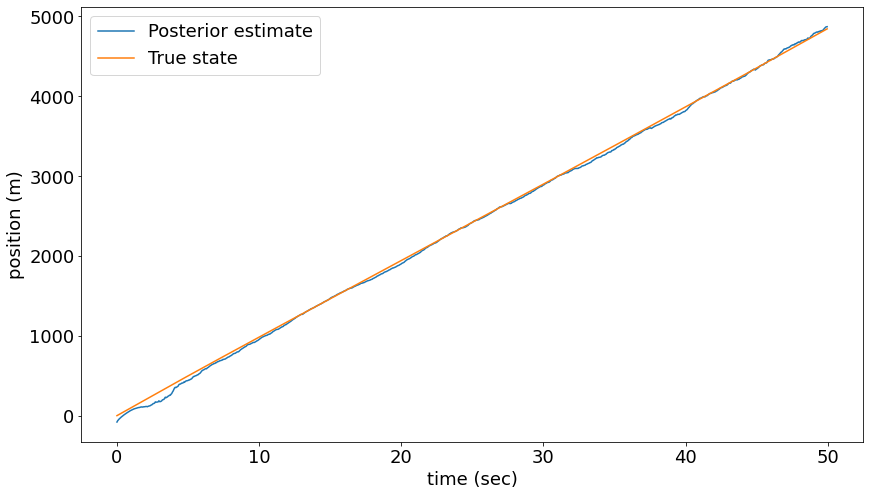

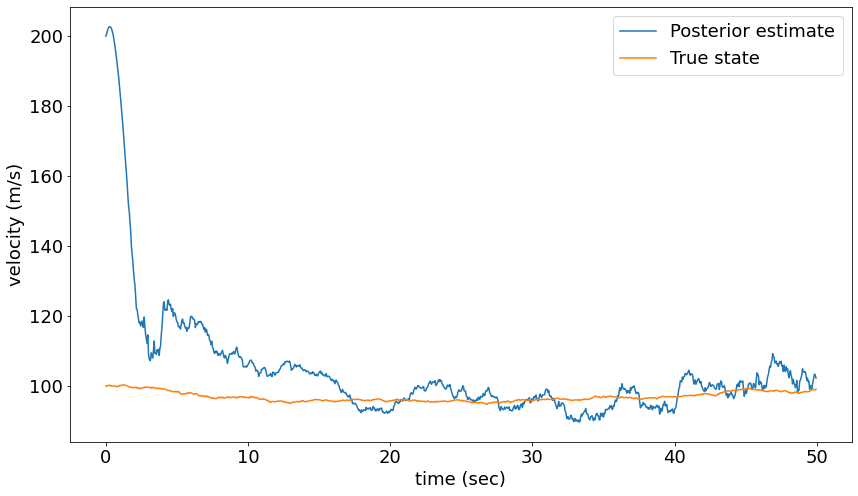

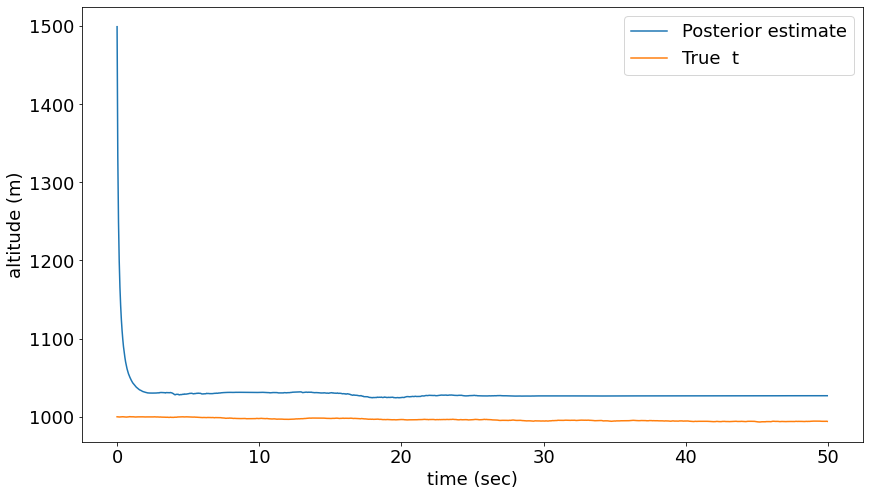

In [103]:
# Inspect
xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)
plot1 = plt.figure(1)
plt.plot(time, xs[:,0])
plt.plot(time, track[:,0])
plt.ylabel("position (m)")
plt.xlabel("time (sec)")
plt.legend(['Posterior estimate', "True state"])
plt.show()

plot2 = plt.figure(2)
plt.plot(time, xs[:,1])
plt.plot(time, track[:,1])
plt.ylabel("velocity (m/s)")
plt.xlabel("time (sec)")
plt.legend(['Posterior estimate', "True state"])
plt.show()

plot3 = plt.figure(3)
plt.plot(time, xs[:,2])
plt.plot(time, track[:,2])
plt.ylabel("altitude (m)")
plt.xlabel("time (sec)")
plt.legend(['Posterior estimate', "True  t"])
plt.show()